### Motivation
降維可以幫助抵抗機器學習最常遇到的問題，龐大的維度規模。

#### MNIST digits database
手寫數位資料庫，握們使用Yann LeCun網站的資料集。
這個資料集可以分成三個子集合，50000實例的訓練集，10000實例驗證集，10000實力的測試集。所有的實例都已經有標籤了。

這資料集包含28x28 pixel的手寫圖片。每個單資料點(圖片)可以數字矩陣來傳送，數字代表著每pixel的深度。也就是28x28矩陣對應28x28 pixel圖。

我們可以平面化每個矩陣成28*28，784維度向量

向量中的每個元素都是0到1之間的浮點樹，代表每個pixel的強度。0是黑色1是白色。標籤號碼為0-9代表圖片中的數字

In [1]:
#import lib

import numpy as np 
import pandas as pd
import os,time
import pickle, gzip

#data viz
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
import matplotlib as mpl

# data prep and model evaluation
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

#algo
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

#### Load MNIST datasets


In [2]:
current_path = os.getcwd()
file = '\\datasets\\mnist_data\\mnist.pkl.gz'

f = gzip.open(current_path+file,'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()
validation_set

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([3, 8, 6, ..., 5, 6, 8], dtype=int64))

In [3]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0],validation_set[1]
X_test, y_test = test_set[0],test_set[1]

#### Verify shapeof datasets

In [4]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [5]:
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))

In [6]:
X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.DataFrame(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.DataFrame(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.DataFrame(data=y_test, index=test_index)


#### Explore data


In [7]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [8]:
y_train

,0
0,5
1,0
2,4
3,1
4,9
...,...
49995,5
49996,0
49997,8
49998,4


In [9]:
def view_digit(example):
    label = y_train.loc[example]
    image = X_train.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d   Label: %d'%(example,label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

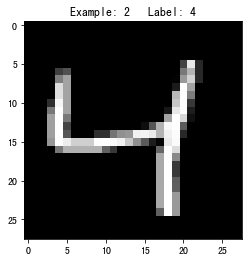

In [10]:
view_digit(2)

#### 線性投影 v.s. 流形學習
兩種最主要的降維分支。

線性投影:
從高維度將資料投影到低維度空間，
例子:<br/>PCA<br/> sigular value decomposition<br/> random projection<br/>

流形學習:
非線性降維，例如:<br/>isomap(學習兩點中曲線距離而非歐式距離)<br/>MDS(multidimensional scaling)<br/> Locally linear embedding(LLE)<br/> t-distributed stochastic neighbor embedding(t-SNE)<br/> dictionary learning
<br/>random trees embedding<br/> independent component analysis

### Principal Component Analysis
有許多種的PCA，包含standard PCA, incremental PCA, sparse PCA, kernal PCA

##### PCA concept
最常見的線性降維技術。演算法會找出能夠保存最多變異(重要訊息)的低維度代表。

PCA利用特徵來解決相關性。如果特徵子集合之間的相關性很高，PCA會試著將高度相關特徵組合在一起，用較少的線性部相關特徵展現資料，找出原本高維資料的最大變異的位址並且將他們投影到低維度空間。這些新展開的資料也稱為主成分。

有這些元素，我們可以重塑原本特徵，不完全是重塑但非常接近。PCA在優化元素時會主動嘗試最小化重塑的偏差。

在MNIST案例中，原本特徵有784維度(d 維度)，PCA將之投影到k維度子空間並且保存最多重要資訊，K維度也稱為主成分。

同時也會減少資料的大小，增加機器學習的表現。
通常我們會先正則化資料確保特徵會在相對的大小，在MNIST資料集中已經事先將特徵正則化，大小介於0-1。


In [11]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components,whiten=whiten,random_state=random_state)


#### 套用 PCA
先設定主成分維原本資料維度(i.e. 784)，PCA會抓取重要資訊開始產生主成分。一旦元素產生，我們會決定有多少的主成分被萃取到。


In [24]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data= X_train_PCA, index = train_index)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.461486,-1.246855,0.046273,-2.151945,-0.247279,-0.925423,0.889330,0.507176,-1.541691,0.689369,...,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.769952e-05,0.000000e+00,-0.000000e+00,-0.000000e+00
1,3.921789,-1.251975,2.335259,-1.340886,-3.421518,-0.725724,-0.206345,-0.345285,0.134086,0.595475,...,4.742170e-09,3.580562e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.123725e-07,9.395818e-07,3.014860e-07,-9.617160e-09
2,-0.203721,1.547937,-0.980331,2.039093,-1.079877,0.112884,-3.312348,1.403171,-0.592898,-0.763839,...,-4.074979e-09,1.525597e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.025918e-07,-1.396577e-06,-2.071702e-06,9.332764e-08
3,-3.148450,-2.296099,1.091154,0.484597,0.066825,2.778972,-1.834356,-0.174753,1.166451,0.052855,...,-2.637537e-09,-1.327225e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.694219e-07,2.036669e-06,6.437483e-07,-1.065743e-06
4,-1.442739,2.871986,0.175652,-0.976909,0.302757,0.120654,-0.376723,-1.478132,1.003752,0.540808,...,2.856352e-08,1.209660e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.287487e-07,5.551837e-06,-2.360454e-06,1.661697e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.147555,-1.972690,-3.739122,1.209665,-0.312002,-0.893656,1.491477,0.013916,-0.385557,-2.202909,...,-1.235761e-09,-7.058333e-09,7.806817e-09,-8.796969e-09,3.067120e-10,-9.134856e-10,1.711371e-08,5.020282e-09,3.332030e-10,7.047642e-10
49996,1.416381,-0.252682,-0.809476,-0.523546,-3.905657,0.187955,-0.449568,-1.231870,-0.104625,0.510858,...,3.175924e-08,6.614789e-08,-4.256530e-09,-6.259228e-09,-3.637915e-09,-1.452559e-09,-1.338935e-08,4.821441e-09,-9.016426e-09,2.229096e-09
49997,-1.425329,-1.957541,-2.551116,0.094593,0.654068,-0.603917,0.312860,-0.047757,0.994548,0.222441,...,1.209317e-08,3.002637e-09,4.055785e-09,5.872140e-09,-4.875055e-09,-2.666693e-09,6.463983e-09,2.125245e-09,-3.535153e-10,-2.285242e-09
49998,-1.507546,1.025468,0.107841,0.276075,2.285549,-0.590754,-0.676684,-0.062367,0.050038,1.578244,...,-6.101628e-09,-2.223911e-09,3.903040e-09,-4.990766e-09,-1.209658e-09,-2.191153e-10,3.466794e-09,2.763308e-09,-2.949933e-09,6.518028e-10


#### 評估PCA
因為沒有完全把維度降到極致

In [13]:
print('Variance Explained by all 784 principal components: ', 
     sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  0.9999999839005775


In [16]:
importanceOfPrincipalComponents = pd.DataFrame(data = pca.explained_variance_ratio_)
print(importanceOfPrincipalComponents)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T
print(importanceOfPrincipalComponents)


                0
0    9.744351e-02
1    7.059821e-02
2    6.216072e-02
3    5.379511e-02
4    4.858052e-02
..            ...
779  1.254976e-16
780  1.224751e-16
781  5.811719e-17
782  4.772935e-17
783  1.306506e-17

[784 rows x 1 columns]
        0         1         2         3         4         5         6    \
0  0.097444  0.070598  0.062161  0.053795  0.048581  0.043196  0.032776   

        7         8         9    ...           774           775  \
0  0.028864  0.027688  0.023659  ...  1.254976e-16  1.254976e-16   

            776           777           778           779           780  \
0  1.254976e-16  1.254976e-16  1.254976e-16  1.254976e-16  1.224751e-16   

            781           782           783  
0  5.811719e-17  4.772935e-17  1.306506e-17  

[1 rows x 784 columns]


In [17]:
print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.4887615]
Variance Captured by First 20 Principal Components:  [0.6439795]
Variance Captured by First 50 Principal Components:  [0.8248605]
Variance Captured by First 100 Principal Components:  [0.91465837]
Variance Captured by First 200 Principal Components:  [0.9665007]
Variance Captured by First 300 Principal Components:  [0.9862489]


可以看出來前10個元素就包含了百分之50的變異數
前100就有90%

<AxesSubplot:>

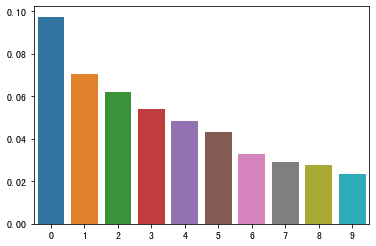

In [18]:
sns.barplot(data=importanceOfPrincipalComponents.loc[:,0:9])

來演示PCA的有效和簡潔的抓舉資料中的變異數，畫出二維來觀察。特別是展示出散點圖第一和第二主要元素來利用真實標籤重點標註起來。

In [22]:
def scatterplot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data = xDF.loc[:,0:1], index = xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis = 1, join='inner')
    tempDF.columns = ['First Vector','second vector','label']
    sns.lmplot(x='First Vector', y ='second vector',hue = 'label', data=tempDF,fit_reg = False)
    ax = plt.gca()
    ax.set_title('Seperation of observation using' + algoName)

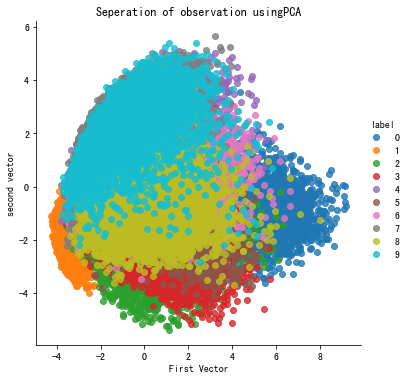

In [23]:
scatterplot(X_train_PCA,y_train,'PCA')

觀察上圖，只有頭兩個主成分，PCA在空間中分割端點有不錯的成效，相似的點大多被歸類在很靠近的距離。也就是說相同數字的圖片彼此之間很接近。

PCA在沒有任何標籤的支持之下完成上述的圖。非監督式學習抓取underlying結構的資料有很優越的力度，幫助發覺標籤空缺所產生的隱藏pattern。

如果我們利用從原784特徵集中萃取最重要的兩個特徵執行相同二維散點圖，使用監督式學習的模型訓練，分離的結果會不顯著。

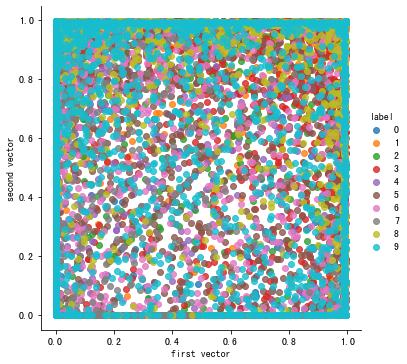

In [28]:
X_train_scatter = pd.DataFrame(data=X_train.loc[:,[350,406]],index=X_train.index)
X_train_scatter = pd.concat((X_train_scatter, y_train), axis=1, join='inner')
X_train_scatter.columns=['first vector','second vector','label']

sns.lmplot(x='first vector',y='second vector',hue='label', data=X_train_scatter, fit_reg=False)


兩張圖很明顯看出來PCA在學習底層架構的資料集會有很強大的功用。即使現在只使用二維的資料，我們可以開始根據顯示的數字有效的分離照片。

#### NOTE:
PCA不只幫助我們發現隱藏的pattern且更簡易的閱讀，同時幫助減少特徵集的大小，在時間和計算資源上大大的減少成本。
有MNIST資料集，因為資料集非常小，只有784特徵值和50000觀察項，因此在訓練時間的沒有太過顯著的差別。

但若資料集的特徵和項目過大，降維會大大的影響效率。
PCA會丟失掉一些原資料特徵集資訊，但是是很有智慧的選擇。模型在訓練的時候使用PCA降維過後的特徵集有可能在準確度的表現沒辦法像利用所有特徵集訓練的模型還要好。

這樣的trades-off是在選擇使否降維的關鍵。速度或是準確度

#### Incremental PCA
當資料集非常龐大且不能存放進記憶體，可以使用漸進增長的PCA，每一個batch都可以fit in 記憶體，每batch大小可以手動設定或自動。

這種形式的batch PCA也就是incremental PCA，

In [32]:
# incremental
from sklearn.decomposition import IncrementalPCA

n_components =784
batch_size = None
incrementalPCA = IncrementalPCA(n_components=n_components, 
                               batch_size = batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA

array([[ 4.61509466e-01,  1.24686481e+00, -4.63732404e-02, ...,
        -4.09257903e-13,  2.97977899e-11, -9.41033915e-08],
       [ 3.92165162e+00,  1.25165147e+00, -2.33550474e+00, ...,
        -2.96705709e-14,  1.65615348e-12, -8.65144221e-10],
       [-2.03710877e-01, -1.54788359e+00,  9.80400124e-01, ...,
        -9.56293681e-15,  2.62811917e-13, -5.06510083e-10],
       ...,
       [-1.42506107e+00,  1.95785620e+00,  2.55120618e+00, ...,
         4.37009446e-14, -4.72842817e-12,  1.76738771e-09],
       [-1.50742748e+00, -1.02531407e+00, -1.07808318e-01, ...,
         7.05215883e-16,  1.01852468e-12,  1.22814529e-09],
       [-1.39639624e+00,  6.46483181e-01,  2.57306673e+00, ...,
         4.43563277e-14, -4.14267987e-12, -6.17867445e-10]])

In [33]:
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA, index = train_index)

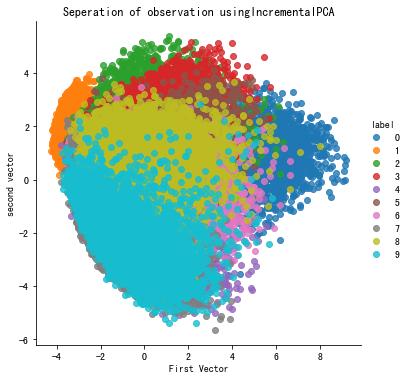

In [35]:
X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA, index= validation_index)
scatterplot(X_train_incrementalPCA,y_train,'IncrementalPCA')

In [36]:
Sparse PCA

The normal PCA algorithm searches for linear combinations in all the input variables, reducing the original feature space as densely as possible. But for some machine learning problems, some degree of sparsity may be preferred. A version of PCA that retains some degree of sparsity—controlled by a hyperparameter called alpha—is known as sparse PCA. The sparse PCA algorithm searches for linear combinations in just some of the input variables, reducing the original feature space to some degree but not as compactly as normal PCA.
Because this algorithm trains a bit more slowly than normal PCA, we will train on just the first 10,000 examples in our training set (out of the total 50,000 examples). We will continue this practice of training on fewer than the total number of observations when the algorithm training times are slow.
For our purposes (i.e., developing some intuition of how these dimensionality reduction algorithms work), the reduced training process is fine. For a better solution, training on the complete training set is advised:

SyntaxError: invalid syntax (<ipython-input-36-b73baf69e6ea>, line 1)

In [37]:
from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:10000,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)

X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = \
    pd.DataFrame(data=X_validation_sparsePCA, index=validation_index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

NameError: name 'scatterPlot' is not defined

In [ ]:
Notice that this scatterplot looks different from that of the normal PCA, as expected. Normal and sparse PCA generate principal components differently, and the separation of points is somewhat different, too.

In [ ]:
Kernel PCA

Normal PCA, incremental PCA, and sparse PCA linearly project the original data onto a lower dimensional space, but there is also a nonlinear form of PCA known as kernel PCA, which runs a similarity function over pairs of original data points in order to perform nonlinear dimensionality reduction.
By learning this similarity function (known as the kernel method), kernel PCA maps the implicit feature space where the majority of data points lie and creates this implicit feature space in a much smaller number of dimensions than the dimensions in the original feature set. This method is especially effective when the original feature set is not linearly separable.
For the kernel PCA algorithm, we need to set the number of components we desire, the type of kernel, and the kernel coefficient, which is known as the gamma. The most popular kernel is the radial basis function kernel, more commonly referred to as the RBF kernel. This is what we will use here:

In [ ]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'
gamma = None
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                      gamma=gamma, n_jobs=n_jobs, random_state=random_state)

kernelPCA.fit(X_train.loc[:10000,:])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=train_index)

X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = \
    pd.DataFrame(data=X_validation_kernelPCA, index=validation_index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

In [ ]:
The two-dimensional scatterplot of the kernel PCA is nearly identical to the one of the linear PCA for our MNIST digits dataset (Figure 3-7). Learning the RBF kernel does not improve the dimensionality reduction.

In [ ]:
Singular Value Decomposition

Another approach to learning the underlying structure of the data is to reduce the rank of the original matrix of features to a smaller rank such that the original matrix can be recreated using a linear combination of some of the vectors in the smaller rank matrix. This is known as singular value decomposition (SVD).
To generate the smaller rank matrix, SVD keeps the vectors of the original matrix that have the most information (i.e., the highest singular value). The smaller rank matrix captures the most important elements of the original feature space.